<h1 align="center">Investigating apical Using Machine Learning</h1>

## Preparing the Dataset


In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import magpy


icsd = pd.read_csv("/home/rhys/PhD/lattice/data/processed/icsd_cleaned.csv")

y = icsd["cu-o_a :"].values

embedding_file="/home/rhys/PhD/magpy/notebooks/embeddings/matscholar_embedding.json"

compositions = icsd["composition :"]
X = magpy.core.descriptors(compositions, embedding_file,
                            operations = ["wmean", "wstd", "max", "min"])

# X = np.vstack((icsd["latc :"].values, icsd["lata :"].values)).T

# X = np.atleast_2d(df["latc :"].values).T
# X = np.hstack((X,strc))

supercon = pd.read_csv("/home/rhys/PhD/lattice/data/processed/super_cleaned.csv")
# x = np.vstack((supercon["latc :"].values, supercon["lata :"].values)).T

compositions = supercon["composition :"]
x = magpy.core.descriptors(compositions, embedding_file,
                            operations = ["wmean", "wstd", "max", "min"])

## Can the we predict apical?
 

In [108]:
from forest import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error as mse

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=59)

# Scale the input features to improve
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 
x = scaler.transform(x)

# Define and fit the model
# Make predictions on the test set
reg = RFR(n_estimators=50).fit(X_train, y_train)
y_pred, y_std = reg.predict(X_test, True)


The R2 Score is 0.8661082761377354
The RMSE is 0.06613018181209887 A


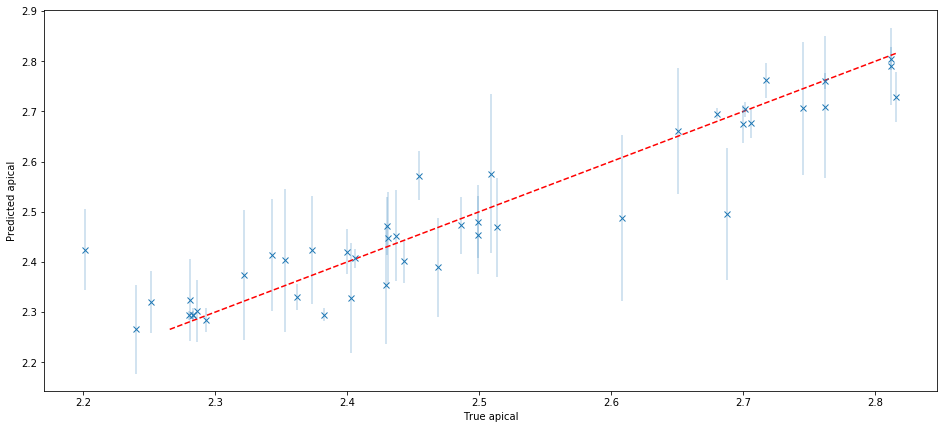

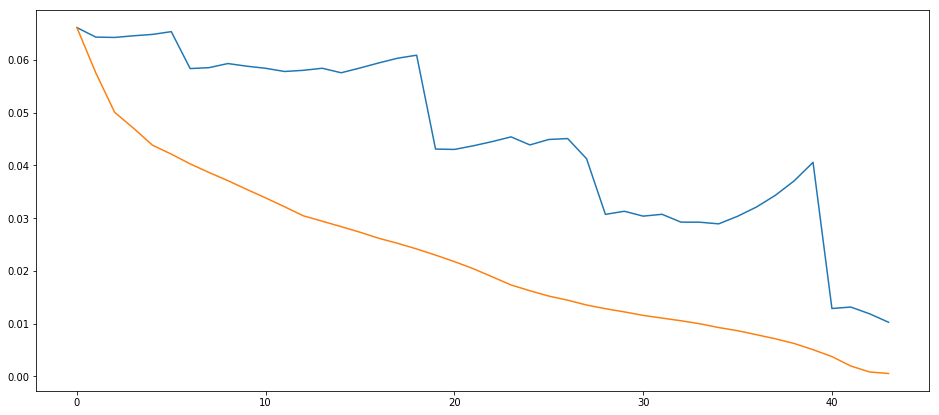

In [109]:
y_pred, y_std = reg.predict(X_test, True)


def plot_graphs(y_test, y_pred, y_std):
    # Evaluate the performance vs target values
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse(y_test, y_pred))
    print("The R2 Score is {}".format(r2))
    print("The RMSE is {} A".format(rmse))

    max_ = np.max([y_test.max(), y_pred.max()])
    min_ = np.max([y_test.min(), y_pred.min()])
    plt.figure(figsize=(16,7))
    plt.xlabel('True apical')
    plt.ylabel('Predicted apical')
    plt.plot([min_, max_], [min_, max_], 'r--')

    plt.errorbar(y_test, y_pred, yerr=y_std, fmt='x', elinewidth=0.4)

    plt.show()

    # sort indices from smallest to largest squared predictive error
    y_std_sort = np.argsort(y_std)
    se_sort = np.argsort(((y_pred - y_test) ** 2))
    err, err_true = [], []
    for j in range(y_test.size, 0, -1):
        less_y_std = y_std_sort[:j]
        less_err = se_sort[:j]
        err.append(mse(y_pred[less_y_std], y_test[less_y_std]))
        err_true.append(mse(y_pred[less_err], y_test[less_err]))

    err=np.sqrt(err)
    err_true=np.sqrt(err_true)    

    plt.figure(figsize=(16,7))
    plt.plot(err)
    plt.plot(err_true)
    plt.show()
    
plot_graphs(y_test, y_pred, y_std)

## Can we improve the results by active learning?

In [110]:
from tqdm import tqdm
for _ in tqdm(range(x.shape[0])):
# for _ in range(5):
    y_est, est_std = reg.predict(x, True)
    index = np.argmin(est_std)
    
    if est_std[index] < 0.01:
        X_train = np.vstack((X_train, x[index]))
        y_train = np.append(y_train, y_est[index])
        x = np.delete(x, index, 0)
        reg = RFR(n_estimators=50).fit(X_train, y_train)
    
    else:
        print("Done")
        break
    
y_pred, y_std = reg.predict(X_test, True)    
plot_graphs(y_test, y_pred, y_std)




  0%|          | 0/1612 [00:00<?, ?it/s]


  0%|          | 1/1612 [00:01<45:06,  1.68s/it]


  0%|          | 2/1612 [00:03<44:54,  1.67s/it]


  0%|          | 3/1612 [00:04<44:43,  1.67s/it]


  0%|          | 4/1612 [00:06<45:48,  1.71s/it]


  0%|          | 5/1612 [00:08<47:24,  1.77s/it]


  0%|          | 6/1612 [00:10<46:29,  1.74s/it]


  0%|          | 7/1612 [00:12<45:42,  1.71s/it]


  0%|          | 8/1612 [00:13<45:18,  1.69s/it]


  1%|          | 9/1612 [00:15<44:53,  1.68s/it]


  1%|          | 10/1612 [00:16<44:39,  1.67s/it]


  1%|          | 11/1612 [00:18<44:26,  1.67s/it]


  1%|          | 12/1612 [00:20<44:37,  1.67s/it]


  1%|          | 13/1612 [00:22<46:42,  1.75s/it]


  1%|          | 14/1612 [00:24<47:07,  1.77s/it]


  1%|          | 15/1612 [00:26<48:44,  1.83s/it]


  1%|          | 16/1612 [00:27<48:33,  1.83s/it]


  1%|          | 17/1612 [00:29<49:03,  1.85s/it]


  1%|          | 18/1612 [00:31<48:39,  1.83s/it]


  1%|          | 19/1612 [0

  8%|▊         | 133/1612 [04:39<1:07:02,  2.72s/it]


  8%|▊         | 134/1612 [04:42<1:06:51,  2.71s/it]


  8%|▊         | 135/1612 [04:45<1:07:13,  2.73s/it]


  8%|▊         | 136/1612 [04:48<1:09:51,  2.84s/it]


  8%|▊         | 137/1612 [04:50<1:07:54,  2.76s/it]


  9%|▊         | 138/1612 [04:53<1:06:55,  2.72s/it]


  9%|▊         | 139/1612 [04:56<1:06:11,  2.70s/it]


  9%|▊         | 140/1612 [04:58<1:05:42,  2.68s/it]


  9%|▊         | 141/1612 [05:01<1:06:50,  2.73s/it]


  9%|▉         | 142/1612 [05:04<1:05:53,  2.69s/it]


  9%|▉         | 143/1612 [05:06<1:05:20,  2.67s/it]


  9%|▉         | 144/1612 [05:09<1:05:05,  2.66s/it]


  9%|▉         | 145/1612 [05:12<1:05:16,  2.67s/it]


  9%|▉         | 146/1612 [05:14<1:05:12,  2.67s/it]


  9%|▉         | 147/1612 [05:17<1:05:14,  2.67s/it]


  9%|▉         | 148/1612 [05:20<1:05:37,  2.69s/it]


  9%|▉         | 149/1612 [05:23<1:06:35,  2.73s/it]


  9%|▉         | 150/1612 [05:26<1:09:50,  2.87s/it]


  9%|▉    

KeyboardInterrupt: 

The R2 Score is 0.8673290749160887
The RMSE is 0.0658280103616728 A


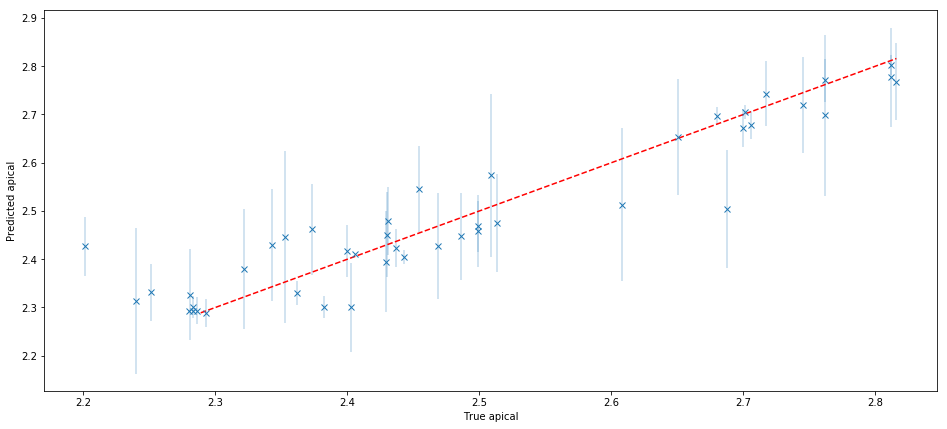

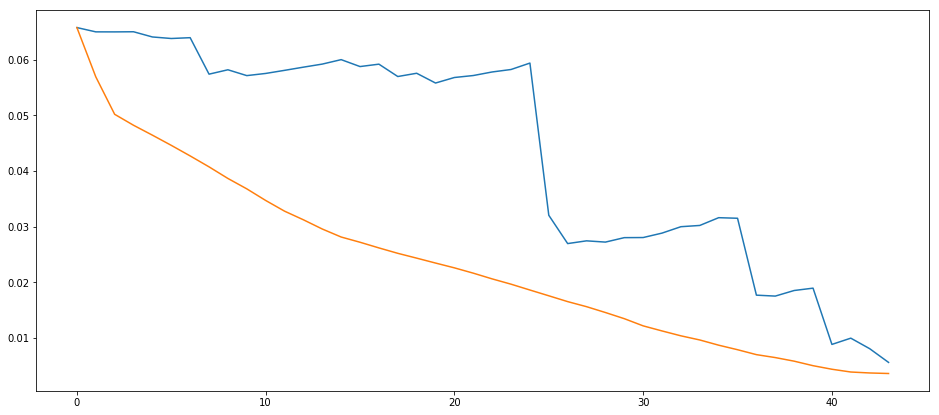

In [111]:
y_pred, y_std = reg.predict(X_test, True)    
plot_graphs(y_test, y_pred, y_std)